Paper about variational Auto Encoder: 
https://arxiv.org/pdf/1703.01488.pdf

ref : https://www.youtube.com/watch?v=IQpP_cH8rrA&t=3s  

MA's implementation on AutoEncoder MNIST: hhttps://colab.research.google.com/drive/17t0mwMgcMsA48lmeIA89Gut202cfeczM?usp=sharing 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt 
torch.manual_seed(1) 

In [ ]:
batch_size=64

In [ ]:

dataset = datasets.MNIST(root="./data", 
                       train=True, 
                       download=True, 
                       transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset=dataset, 
                                   batch_size=batch_size, 
                                   shuffle=True) 
print(len(dataset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

60000



# (MNIST)  FIRST IMPLEMENTATION VERISON

DUE TO KL LOSS HAVE LARGER RANGE THEN DOMINATE THE RECONSTRUCTION LOSS (SO IT GENERATE SAME IMAGE EVERY TIME) 

In [ ]:
# Version 1 
class SimpleLinearVAE_v1(nn.Module):
  '''   '''
  def __init__(self, latent_vectors=64):
    super().__init__()
    self.latent_vectors = latent_vectors
    self.encoder = nn.Sequential(
        nn.Linear(28*28, latent_vectors*2)
    )
    self.decoder = nn.Sequential(
        nn.Linear(latent_vectors, 28*28)
    )
  
  def reparameterize(self, mu, log_var):
    ''' having X of each batch, we calc the mu and var; 
        then sample from that normal distribution'
        -> làm lại phần này trong pyro, nó chính là chỗ hàm guide á ! 
      ''' 
    std = torch.exp(0.5*log_var)
    eps = torch.rand_like(std)
    sample = mu + (eps * std) 
    return sample 

  def forward(self, X, encoding=True):
    if encoding == True: 
      x = self.encoder(X)
      h = x.view(-1, 2, self.latent_vectors)
    
      mu = h[:, 0,:  ]
      log_var = h[:, 1, :] 

    else:
      mu =X[0]
      log_var = X[1]
    z = self.reparameterize(mu, log_var)
    # decoding
    reconstruction = torch.sigmoid(self.decoder(z)) # should there be a sigmoid here 
    return reconstruction, mu, log_var  


def get_final_loss(bce_loss, mu, log_var):
  bce = bce_loss 
  kl_div_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  return bce +  kl_div_loss 

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch  0 | Train Loss: 3574.26049805 | Construction Loss 2965.68676758


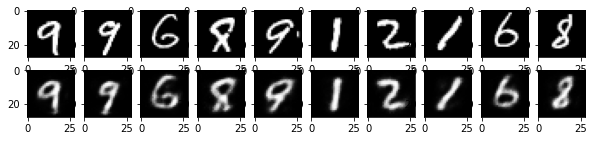

In [ ]:
model = SimpleLinearVAE_v1()
criterion = nn.BCELoss(size_average=False)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr = 1e-3
) 

epochs = 1
losses = [] 
outputs = []
representations = []
for epoch in range(epochs):
  for img, label in loader:
    # TODO: plot every first 10 image in an epoch 
    img = img.reshape(-1, 28*28)
    (reconstruction, mu, log_var ) = model(img)
    _bce_loss=criterion(reconstruction, img)

    final_loss = get_final_loss(_bce_loss, mu, log_var)

    losses.append(final_loss.item())

    outputs.append(reconstruction)
    
    optimizer.zero_grad()
    final_loss.backward()
    optimizer.step()
    
  print('Epoch {: 2} | Train Loss: {:10.8f} | Construction Loss {:10.8f}'.format(epoch, final_loss, _bce_loss))


  fig, ax = plt.subplots(2, 10, figsize=(10, 2))
  plot_imgs = img.detach()[0:10, :]
  plot_recon = reconstruction.detach()[0:10,:]
  for idx, im in enumerate(zip(plot_imgs, plot_recon)):
    ax[0][idx].imshow(im[0].reshape(28,28), cmap='gray') 
    ax[1][idx].imshow(im[1].reshape(28,28), cmap='gray')
  plt.show( )


 

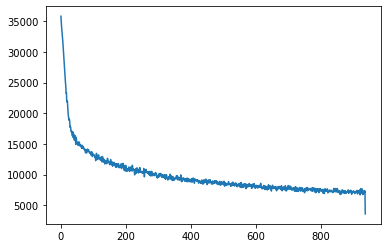

In [ ]:
plt.plot([i for i in losses[0:1000]])

#SOME IMAGE THAT GENERATE FROM THE P(Z|X) DISTRIBUTION
the image look still quite stupid but it's fine !
 

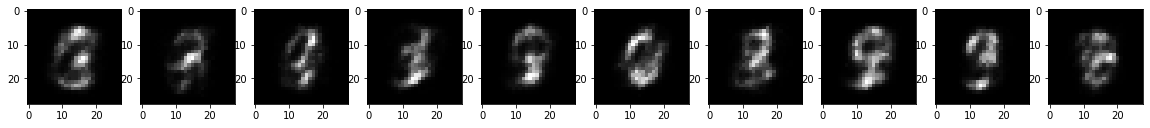

In [ ]:
import numpy as np

with torch.no_grad(): 
  fig, ax = plt.subplots(1, 10, figsize=(20, 3)) 
  # print(ax)
  for idx in range(0,10): 
    mu = torch.Tensor(np.random.randint(2, size=64))
    log_var = torch.Tensor(np.zeros((1, 64))) 
    new_img = reconstruction = model.forward((mu, log_var), encoding=False)[0] 
    ax[idx].imshow(new_img[0].reshape(28, 28), cmap='gray')
 


TODO: Convert code to Pyro 
# http://pyro.ai/examples/vae.html 
- Suing 

# (MNIST) SECOND VERSION -> UNNESSARY 
-Split Encoder and Decoder into seperate (this is useless by the way) 

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.hidden_size = hidden_size 
    self.encoder = nn.Sequential(
      nn.Linear(input_size, hidden_size*2)
    ) 
  
  def forward(self, X):
    x = self.encoder(X)
    x = x.view(-1, 2, self.hidden_size)
    
    mu = x[:, 0, :] # should be improve on this part 
    log_var = x[:, 1, :]
    return mu, log_var 


class Decoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.decoder = nn.Sequential(
      nn.Linear(hidden_size, output_size)
    )

  @staticmethod 
  def reparameterize(mu, log_var): 
    std = torch.exp(0.5*log_var) 
    eps = torch.rand_like(std) # sampling is used here -> can be modified to pyro.sample 
    return mu + (eps * std) 

  def forward(self, mu, log_var):
    z = self.reparameterize(mu, log_var) # how to propagate the gradient at this step due to sampling ? 
    reconstr = self.decoder(z)
    return reconstr, mu, log_var

class SimpleLinearVAE_v2(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.encoder = Encoder(input_size, hidden_size, output_size)
    self.decoder = Decoder(input_size, hidden_size, output_size)

  def forward(self, X, encoding=True):
    # using pytorch 
    if encoding == True: 
      mu, log_var = self.encoder(X)
    else: 
      mu, log_var = X[0], X[1]
    reconstr, mu, log_var = self.decoder(mu, log_var) #** 
    return reconstr, mu, log_var 


def get_final_loss(recontruction_loss, mu, log_var):
  kl_div_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) # ELBO loss 
  return recontruction_loss +  kl_div_loss

Epoch  0 | Train Loss: 716.52606201 | Construction Loss : 530.35205078


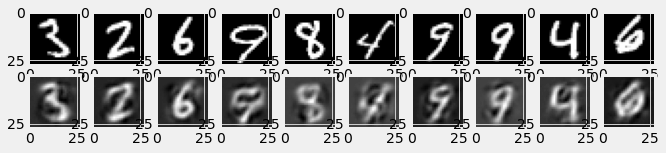

Epoch  1 | Train Loss: 741.46215820 | Construction Loss : 539.37963867


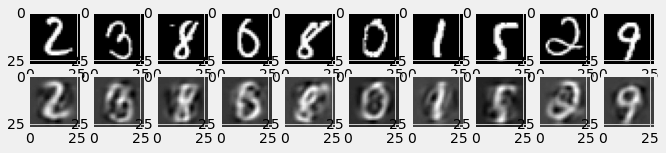

Epoch  2 | Train Loss: 729.38854980 | Construction Loss : 507.05773926


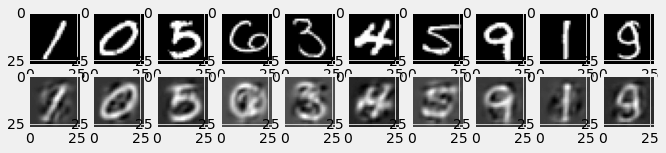

In [ ]:
model = SimpleLinearVAE_v2(28*28, 64, 28*28)
criterion = nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr = 1e-3
)  

epochs = 3
losses = [] 
mse_losses = [] 
outputs = []

representations = []

for epoch in range(epochs):
  for img, label in loader:
    # TODO: plot every first 10 image in an epoch 
    img = img.reshape(-1, 28*28)
    (reconstruction, mu, log_var ) = model(img)
    _mse_loss=criterion(reconstruction, img)

    mse_losses.append(_mse_loss.item())
    final_loss = get_final_loss(_mse_loss, mu, log_var) 

    loss = final_loss 
    losses.append(final_loss.item())

    outputs.append(reconstruction)
    
    optimizer.zero_grad()
    final_loss.backward()
    optimizer.step()
    
  print('Epoch {: 2} | Train Loss: {:10.8f} | Construction Loss : {:10.8f}'.format(epoch, loss, _mse_loss))


  fig, ax = plt.subplots(2, 10, figsize=(10, 2))
  plot_imgs = img.detach()[0:10, :]
  plot_recon = reconstruction.detach()[0:10,:]
  for idx, im in enumerate(zip(plot_imgs, plot_recon)):
    ax[0][idx].imshow(im[0].reshape(28,28), cmap='gray') 
    ax[1][idx].imshow(im[1].reshape(28,28), cmap='gray')
  plt.show( )


 